# RSNA Intracranial Hemorrhage Detection 

<b>Competition Overview</b><br/><br/>
Intracranial hemorrhage, bleeding that occurs inside the cranium, is a serious health problem requiring rapid and often intensive medical treatment. For example, intracranial hemorrhages account for approximately 10% of strokes in the U.S., where stroke is the fifth-leading cause of death. Identifying the location and type of any hemorrhage present is a critical step in treating the patient.

Diagnosis requires an urgent procedure. When a patient shows acute neurological symptoms such as severe headache or loss of consciousness, highly trained specialists review medical images of the patient’s cranium to look for the presence, location and type of hemorrhage. The process is complicated and often time consuming.

<b>What am i predicting?</b><br/><br/>
In this competition our goal is to predict intracranial hemorrhage and its subtypes. Given an image the we need to predict probablity of each subtype. This indicates its a multilabel classification problem.

<b>Competition Evaluation Metric</b><br/><br/>
Evaluation metric is weighted multi-label logarithmic loss. So for given image we need to predict probality for each subtype. There is also an any label, which indicates that a hemorrhage of ANY kind exists in the image. The any label is weighted more highly than specific hemorrhage sub-types.

<b>Note:</b>The weights for each subtype for calculating weighted multi-label logarithmic loss is **not** given as part of the competition. We will be using binary cross entropy loss as weights are not available

<b>Dataset Description</b>

The dataset is divided into two parts

1. Train
2. Test

**1. Train**
Number of rows: 40,45,548 records.
Number of columns: 2

Columns:

**Id**: An image Id. Each Id corresponds to a unique image, and will contain an underscore.

Example: ID_28fbab7eb_epidural. So the Id consists of two parts one is image file id ID_28fbab7eb and the other is sub type name

**Label**: The target label whether that sub-type of hemorrhage (or any hemorrhage in the case of any) exists in the indicated image. 1 --> Exists and 0 --> Doesn't exist.

**2. Test**
Number of rows: 4,71,270 records.

Columns:

**Id**: An image Id. Each Id corresponds to a unique image, and will contain an underscore.

Example: ID_28fbab7eb_epidural. So the Id consists of two parts one is image file id ID_28fbab7eb and the other is sub type name

In [1]:
import numpy as np
import pandas as pd
import pydicom
import cv2
import os
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
from keras.applications.resnet50 import ResNet50
from keras.utils import to_categorical, Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras.optimizers import RMSprop,Adam
from keras.applications import VGG19, VGG16, ResNet50
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm_notebook as tqdm
import keras
from sklearn.model_selection import train_test_split
from math import ceil, floor

Using TensorFlow backend.


In [2]:
input_folder = '../input/rsna-intracranial-hemorrhage-detection/'

In [3]:
train_df = pd.read_csv(input_folder + 'stage_1_train.csv')
train_df.head()

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0


In [4]:
train_df['sub_type'] = train_df['ID'].apply(lambda x: x.split('_')[-1])
train_df['file_name'] = train_df['ID'].apply(lambda x: '_'.join(x.split('_')[:2]) + '.dcm')

In [5]:
train_df.head()

,ID,Label,sub_type,file_name
0,ID_63eb1e259_epidural,0,epidural,ID_63eb1e259.dcm
1,ID_63eb1e259_intraparenchymal,0,intraparenchymal,ID_63eb1e259.dcm
2,ID_63eb1e259_intraventricular,0,intraventricular,ID_63eb1e259.dcm
3,ID_63eb1e259_subarachnoid,0,subarachnoid,ID_63eb1e259.dcm
4,ID_63eb1e259_subdural,0,subdural,ID_63eb1e259.dcm


In [6]:
train_df.shape

(4045572, 4)

In [7]:
train_df.drop(train_df[train_df['file_name'] == 'ID_6431af929.dcm'].index, inplace=True)

In [8]:
train_df.shape

(4045566, 4)

In [9]:
train_final_df = pd.pivot_table(train_df.drop(columns='ID'), index="file_name", \
                                columns="sub_type", values="Label")
train_final_df.head()

sub_type,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
file_name,,,,,,
ID_000039fa0.dcm,0,0,0,0,0,0
ID_00005679d.dcm,0,0,0,0,0,0
ID_00008ce3c.dcm,0,0,0,0,0,0
ID_0000950d7.dcm,0,0,0,0,0,0
ID_0000aee4b.dcm,0,0,0,0,0,0


In [10]:
data_train, data_val = train_test_split(train_final_df, test_size=0.2)

In [11]:
data_train.shape, data_val.shape

((539405, 6), (134852, 6))

In [12]:
from math import log

def _normalize(x):
    x_max = x.max()
    x_min = x.min()
    if x_max != x_min:
        z = (x - x_min) / (x_max - x_min)
        return z
    return np.zeros(x.shape)

def sigmoid_window(img, window_center, window_width, U=1.0, eps=(1.0 / 255.0), desired_size=(256, 256)):
    intercept, slope = img.RescaleIntercept, img.RescaleSlope
    img = img.pixel_array * slope + intercept
    
    # resizing already to save computation
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    ue = log((U / eps) - 1.0)
    W = (2 / window_width) * ue
    b = ((-2 * window_center) / window_width) * ue
    z = W * img + b
    img = U / (1 + np.power(np.e, -1.0 * z))
    
    img = _normalize(img)
    
    return img

def sigmoid_bsb_window(img, desired_size):
    brain_img = sigmoid_window(img, 40, 80, desired_size=desired_size)
    subdural_img = sigmoid_window(img, 80, 200, desired_size=desired_size)
    bone_img = sigmoid_window(img, 600, 2000, desired_size=desired_size)
    
    bsb_img = np.zeros((brain_img.shape[0], brain_img.shape[1], 3))
    bsb_img[:, :, 0] = brain_img
    bsb_img[:, :, 1] = subdural_img
    bsb_img[:, :, 2] = bone_img
    return bsb_img

In [13]:
path_train_img = input_folder + 'stage_1_train_images/'
path_test_img = input_folder + 'stage_1_test_images/'

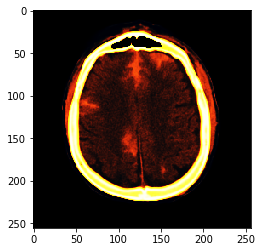

In [14]:
dicom = pydicom.dcmread(path_train_img + 'ID_5c8b5d701' + '.dcm')
plt.imshow(sigmoid_bsb_window(dicom, desired_size=(256, 256)));

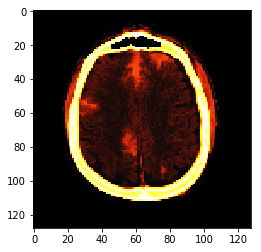

In [15]:
def _read(path, desired_size):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        img = sigmoid_bsb_window(dcm, desired_size)
    except:
        img = np.zeros(desired_size)
    
    return img

# Another sanity check 
plt.imshow(
    _read(path_train_img+'ID_5c8b5d701'+'.dcm', (128, 128))
);

In [16]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, list_IDs, labels=None, batch_size=1, img_size=(512, 512, 3), 
                 img_dir=path_train_img, *args, **kwargs):

        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        
        if self.labels is not None:
            X, Y = self.__data_generation(list_IDs_temp)
            return X, Y
        else:
            X = self.__data_generation(list_IDs_temp)
            return X
        
    def on_epoch_end(self):
        
        
        if self.labels is not None: # for training phase we undersample and shuffle
            # keep probability of any=0 and any=1
            keep_prob = self.labels.iloc[:, 0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = np.arange(len(self.list_IDs))[keep]
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.img_size))
        
        if self.labels is not None: # training phase
            Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID, self.img_size)
                Y[i,] = self.labels.loc[ID].values
        
            return X, Y
        
        else: # test phase
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            
            return X

In [17]:
q_size = 224
img_channel = 3
num_classes = 6

In [18]:
batch_size = 128
train_generator = DataGenerator(list_IDs=data_train.index, labels=data_train, batch_size=batch_size, 
                                img_size=(q_size, q_size, 3), img_dir=path_train_img)
val_generator = DataGenerator(list_IDs=data_val.index, labels=data_val, batch_size=batch_size, 
                                img_size=(q_size, q_size, 3), img_dir=path_train_img)

In [19]:
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)


def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)


def weighted_log_loss_metric(trues, preds):
    """
    Will be used to calculate the log loss 
    of the validation set in PredictionCheckpoint()
    ------------------------------------------
    """
    class_weights = [2., 1., 1., 1., 1., 1.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()

In [20]:
from keras.callbacks import ModelCheckpoint

In [21]:
from keras.callbacks import Callback
from keras import backend as K

class CyclicLR(Callback):
    def __init__(
            self,base_lr=0.001,
            max_lr=0.006,step_size=2000.,
            mode='triangular',gamma=1.,
            scale_fn=None,scale_mode='cycle'):
        
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2','exp_range']:
            raise KeyError("mode must be one of 'triangular', "
                           "'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)


In [22]:
clr = CyclicLR(base_lr=5e-4, max_lr=0.009,step_size=300, mode='triangular', gamma=0.99994)

In [23]:
filepath="weights-improvement.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='weighted_loss', verbose=1, \
                             save_best_only=True, mode='min')

callbacks_list = [checkpoint, clr]

In [24]:
!pip install efficientnet==0.0.4

  Created wheel for efficientnet: filename=efficientnet-0.0.4-cp36-none-any.whl size=14288 sha256=de133e6e020da66b9da2a0da8daa3d9e86e83a3374b2b379225f4bbf5ef664b6
  Stored in directory: /tmp/.cache/pip/wheels/5c/34/68/a611a699a28239e964ccf144c0e767cdb5439fee82ec5de6e0
Successfully built efficientnet


In [25]:
import efficientnet

In [26]:
conv_base = keras.applications.InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(q_size, q_size, img_channel))
conv_base.trainable = True

87916544/87910968 [==============================] - 4s 0us/step


In [27]:
effnet = efficientnet.EfficientNetB0(weights='imagenet',
                        include_top=False,
                        input_shape=(224, 224, 3))

16719872/16717576 [==============================] - 1s 0us/step


In [28]:
effnet.trainable = False

In [29]:
effnet.input_shape

(None, 224, 224, 3)

In [30]:
x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(conv_base.output)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(keras.backend.int_shape(x)[1], activation="relu", name="dense_hidden_1")(x)
x = keras.layers.Dropout(0.1)(x)
out = keras.layers.Dense(6, activation="sigmoid", name='dense_output')(x)
model = keras.models.Model(inputs=conv_base.input, outputs=out)

In [31]:
model.compile(loss=weighted_log_loss, optimizer=Adam(), metrics=[weighted_loss])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [32]:
# model = Sequential()
# model.add(effnet)
# # model.add(keras.layers.GlobalAveragePooling2D(name='avg_pool'))
# model.add(Dropout(0.3))
# model.add(Flatten())
# model.add(Dense(32, activation='relu'))
# model.add(Dense(6, activation='sigmoid'))


# # # model.add(Dense(64, activation='relu'))
# # # model.add(Dropout(0.5))
# # # model.add(Dense(32, activation='relu'))
# # # model.add(Dropout(0.5))
# # # model.add(Dense(6, activation='sigmoid'))
# # # from keras.models import Model
# # # from keras.layers import Input, Dense

# # # a = Input(shape=(224, 224, 3))
# # # a = effnet(a)
# # # x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(a)
# # # x = keras.layers.Dropout(0.2)(x)
# # # x = keras.layers.Dense(keras.backend.int_shape(x)[1], activation="relu", name="dense_hidden_1")(x)
# # # x = keras.layers.Dropout(0.1)(x)
# # # out = keras.layers.Dense(6, activation="sigmoid", name='dense_output')(x)

# # # model = keras.models.Model(inputs=a, outputs=out)

# model.compile(loss=weighted_log_loss, optimizer=Adam(), metrics=[weighted_loss])

# model.summary()

In [33]:
model.fit_generator(generator=train_generator,
                              validation_data=val_generator,
                              epochs=4, workers=os.cpu_count()*2, callbacks=callbacks_list)

Epoch 1/4


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power


1564/1564 [==============================] - 3435s 2s/step - loss: 0.2244 - weighted_loss: 0.1923 - val_loss: 0.6349 - val_weighted_loss: 0.2358

Epoch 00001: weighted_loss improved from inf to 0.19233, saving model to weights-improvement.hdf5
Epoch 2/4
1561/1561 [==============================] - 3375s 2s/step - loss: 0.2077 - weighted_loss: 0.1780 - val_loss: 0.2423 - val_weighted_loss: 0.1894

Epoch 00002: weighted_loss improved from 0.19233 to 0.17804, saving model to weights-improvement.hdf5
Epoch 3/4
1566/1566 [==============================] - 3451s 2s/step - loss: 278360175505868839625628319744.0000 - weighted_loss: 238594430895644198977568505856.0000 - val_loss: 0.1466 - val_weighted_loss: 0.1605

Epoch 00003: weighted_loss did not improve from 0.17804
Epoch 4/4
1566/1566 [==============================] - 3443s 2s/step - loss: 0.1809 - weighted_loss: 0.1551 - val_loss: 0.3426 - val_weighted_loss: 0.2200

Epoch 00004: weighted_loss improved from 0.17804 to 0.15509, saving mode